In [1]:
# Script for investigating amplitude dependence of potential

@everywhere using Distributions
@everywhere using Base.Test
@everywhere using StatsBase
@everywhere using BenchmarkTools
using MCMCDiagnostics
@everywhere src_path = "../../Source/"
@everywhere include(src_path*"types.jl")
@everywhere include(src_path*"functions_msc.jl")
@everywhere include(src_path*"functions_neighbors.jl")
@everywhere include(src_path*"functions_types.jl")
@everywhere include(src_path*"functions_symmetric_energy.jl")
@everywhere include(src_path*"functions_mc.jl")
@everywhere include(src_path*"functions_thermalization.jl")
@everywhere include(src_path*"functions_observables.jl")
@everywhere include(src_path*"functions_symmetries.jl")
include(src_path*"functions_plots_and_files.jl")
using Plots
pyplot()



Plots.PyPlotBackend()

In [2]:


THERM_FRAC = 1/10
DT_MAX = 1000
DT_MIN = 100
MEASURE_FILE = "measured.statelist"

@everywhere const two_pi = 2π

# We run a simulation with the parameters
g = 1.0    # Gauge coupling
ν = 0.3    # Anisotropy

# Other parameters
L = 12     # System length
L₃ = 12
T_list = [0.7, 0.9, 1.1, 1.3]# [T for T = 0.4:0.1:3.5]#[T for T = 0.2:0.2:1.6]
κ₅ = 1.0

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = 0.0/L
println("f set to $(f)")
sim = Controls(π-π/12, 1.0, 4.0)

M = 400
# Setup measurement storage
N_T = length(T_list)
#u⁺_avg_by_T = Array{Float64}(N_T); u⁻_avg_by_T = Array{Float64}(N_T)
#u⁺_err_by_T = Array{Float64}(N_T); u⁻_err_by_T = Array{Float64}(N_T)

#η⁺_avg_by_T = Array{Float64}(N_T); η⁻_avg_by_T = Array{Float64}(N_T)
#η⁺_err_by_T = Array{Float64}(N_T); η⁻_err_by_T = Array{Float64}(N_T)

#Υ_avg_by_T = Array{Float64}(N_T)
#Υ_err_by_T = Array{Float64}(N_T);

ρˣ₂_avg_by_T = Array{Float64}(N_T); ρˣ₃_avg_by_T = Array{Float64}(N_T); ρʸ₁_avg_by_T = Array{Float64}(N_T)
ρˣ₂_err_by_T = Array{Float64}(N_T); ρˣ₃_err_by_T = Array{Float64}(N_T); ρʸ₁_err_by_T = Array{Float64}(N_T)
ρʸ₃_avg_by_T = Array{Float64}(N_T); ρᶻ₁_avg_by_T = Array{Float64}(N_T); ρᶻ₂_avg_by_T = Array{Float64}(N_T)
ρʸ₃_err_by_T = Array{Float64}(N_T); ρᶻ₁_err_by_T = Array{Float64}(N_T); ρᶻ₂_err_by_T = Array{Float64}(N_T)

# Make ab inito un-correlated phases state
nw = max(1,nprocs()-1) # The number of low temperature states needed
init_syst_list = Array{SystConstants, 1}(nw+1)
init_syst_list[1:nw] = [SystConstants(L, L₃, 1/g^2, ν, κ₅, f, 1/T_list[1]) for i = 1:nw] # Make nw low temp-states
init_syst_list[nw+1] = SystConstants(L, L₃, 1/g^2, ν, κ₅, f, 1/T_list[end])              # Make final high temp state.
init_ψ_list = [State(1, syst; u⁺=1.0, u⁻=0.0) for syst in init_syst_list]
init_sim_list = [copy(sim) for syst in init_syst_list];

T_list = reverse(T_list);


f set to 0.0


In [3]:
N = length(init_ψ_list[1].lattice)
println("Ab inito energies:")
println([E(ψ)/N for ψ in init_ψ_list])
# Run these states until the energy-curve is flat.
println("Thermalizing to temperatures")
println([1/ψ.consts.β for ψ in init_ψ_list])
println("Thermalizing $(nw+1) initial states from correlated state")
thermalized, time, init_ψ_list, init_sim_list, E_matrix = @time flatThermalization!(init_ψ_list, init_sim_list;
    visible=true, N_SUBS=10);

# Plot last energies
plt = plot(1:size(E_matrix,2), [E_matrix[s,:]./N for s = 1:size(E_matrix,1)]; xlabel="MCS", ylabel="Total En", title="Last thermalization interval")
savefig(plt, "initial_states_thermalization_last_average.pdf")

println("Initial energies:")
println([E(init_ψ_list[i])/N for i = 1:length(init_ψ_list)])



Ab inito energies:
[-1.0, -1.0, -1.0, -1.0]
Thermalizing to temperatures
[0.7, 0.7, 0.7, 1.3]
Thermalizing 4 initial states from correlated state
Controls after initial adjustment:
State	θmax			umax	Amax
1	2.1598449493429825	1.0	0.3511659807956104
2	1.9198621771937623	1.0	0.3950617283950617
3	1.9198621771937623	1.0	0.3950617283950617
4	2.8797932657906435	1.0	0.7901234567901234
With lowest AR: 0.30196759259259254,	highest AR: 0.3100694444444444

Worker 1 not flat.	⟨ΔE⟩ = 43.34346094982698 ± 21.078586910506058
Thermalization not yet reached after 1000 MCS
Worker 2 not flat.	⟨ΔE⟩ = -30.431225244395762 ± 15.021180641961461
Thermalization not yet reached after 3000 MCS
Worker 1 not flat.	⟨ΔE⟩ = -42.55828043923157 ± 19.664582238009444
Thermalization not yet reached after 5000 MCS
Worker 3 not flat.	⟨ΔE⟩ = -51.838492333261286 ± 15.708893226990737
Thermalization not yet reached after 7000 MCS

All workers flat.
  ⟨ΔE⟩{1} =	19.468727696589724 ± 24.586866334351313
  ⟨ΔE⟩{2} =	8.726982085766963 ±

In [4]:

# Then preform thermalization and measurement for each temperature individually in separate folders
@time for (i, T) in enumerate(T_list)
    println("\n\n*****************************************************************************\nEntering simulation of T = $(T)")
    flush(STDOUT)
    dir_name = "T_$(T)"
    mkcd(dir_name)

    # Start with fresh states
    ψ_list = [copy(ψ) for ψ in init_ψ_list]
    sim_list = [copy(sim) for ψ in ψ_list]
    println("Thermalizing from high (T=$(1/ψ_list[end].consts.β)) and low temperature (T=$(1/ψ_list[1].consts.β))")
    # Update to new temperature
    syst = SystConstants(L, L₃, 1/g^2, ν, κ₅, f, 1/T)
    for ψ in ψ_list
        ψ.consts = syst
    end
    
    println("Energies before thermalization:")
    println([E(ψ)/N for ψ in ψ_list])
    #println([E(ψ_ref)/N, [E(ψ)/N for ψ in ψ_w]...])
    # Thermalize states
    thermalized, t₀, ψ_list, sim_list, E_matrix = @time flatThermalization!(ψ_list, sim_list;
    visible=true, N_SUBS=10, T_QUENCH=time);
    #@time thermalized, t₀, ψ_ref, E_ref, sim_ref, ψ_w, E_w, sim_w = thermalizeLite!(ψ_ref, ψ_w, copy(sim); visible=true,
    #    STABILITY_CUTOFF=60000)
    println("Energies after thermalization:")
    #println([E(ψ_ref)/N, [E(ψ)/N for ψ in ψ_w]...])
    println([E(ψ)/N for ψ in ψ_list])

    # Preform measurements by saving states to file.
    Δt = max(DT_MIN, min(DT_MAX, ceil(Int64, t₀*THERM_FRAC)))
    println("Δt = $(Δt), which means that we will do in total $(M*Δt) MCS")
    @time (ρˣ₂_avg_by_T[i], ρˣ₂_err_by_T[i], ρˣ₃_avg_by_T[i], ρˣ₃_err_by_T[i], ρʸ₃_avg_by_T[i], ρʸ₃_err_by_T[i],
        ρʸ₁_avg_by_T[i], ρʸ₁_err_by_T[i], ρᶻ₁_avg_by_T[i], ρᶻ₁_err_by_T[i], ρᶻ₂_avg_by_T[i], ρᶻ₂_err_by_T[i],
        _1, _2, _3, _4, _5, _6, _7, _8) = parallelMeasureGS!(ψ_list, sim_list[1], M, Δt)
    #@time measurementSeries!(ψ_list, sim_ref, M, Δt; filename=MEASURE_FILE)

    # Load states to memory.
    #ψ_measured = loadStates(MEASURE_FILE)
    #M = length(ψ_measured)

    # Use states to produce lists of order-parameters
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    #η⁺_list, η⁻_list = measureOrdParam(ψ_measured)
    # Get averages and errors
    #η⁺_avg, η⁺_err = avgErr(η⁺_list); η⁻_avg, η⁻_err = avgErr(η⁻_list)
    # Get correlation times
    #η⁺_τ = M/effective_sample_size(η⁺_list); η⁻_τ = M/effective_sample_size(η⁻_list)
    #η⁺_avg_r, η⁺_err_r = scientificRounding(η⁺_avg, η⁺_err); η⁻_avg_r, η⁻_err_r = scientificRounding(η⁻_avg, η⁻_err)
    #println("|⟨η⁺⟩| = $(η⁺_avg_r) ± $(η⁺_err_r)\t\tτ = $(η⁺_τ)")
    #println("|⟨η⁻⟩| = $(η⁻_avg_r) ± $(η⁻_err_r)\t\tτ = $(η⁻_τ)")
    
    # Save result to array
    #η⁺_avg_by_T[i] = η⁺_avg; η⁻_avg_by_T[i] = η⁻_avg;
    #η⁺_err_by_T[i] = η⁺_err; η⁻_err_by_T[i] = η⁻_err;
    
    # Use states to produce list of helicity moduli
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    #Υ_list = measureHelicityModulus(ψ_measured)
    # Get averages and errors
    #Υ_avg, Υ_err = avgErr(Υ_list)
    # Get correlation times
    #Υ_τ = M/effective_sample_size(Υ_list)
    #Υ_avg_r, Υ_err_r = scientificRounding(Υ_avg, Υ_err)
    #println("⟨Υ⟩ = $(Υ_avg_r) ± $(Υ_err_r)\t\tτ = $(Υ_τ)")
    
    # Save result to array
    #Υ_avg_by_T[i] = Υ_avg; Υ_err_by_T[i] = Υ_err

    # Use states to produce lists of gauge-stiffnesses
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    #ρˣ₂_list, ρˣ₃_list, ρʸ₁_list, ρʸ₃_list, ρᶻ₁_list, ρᶻ₂_list = gaugeStiffness(ψ_measured)
    # Get averages and errors
    #ρˣ₂_avg, ρˣ₂_err = avgErr(ρˣ₂_list); ρˣ₃_avg, ρˣ₃_err = avgErr(ρˣ₃_list); ρʸ₁_avg, ρʸ₁_err = avgErr(ρʸ₁_list)
    # Get correlation times and rounding for print
    #ρˣ₂_τ = M/effective_sample_size(ρˣ₂_list)
    #ρˣ₂_avg_r, ρˣ₂_err_r = scientificRounding(ρˣ₂_avg, ρˣ₂_err);
    #println("ρˣ(k₂) = $(ρˣ₂_avg_r) ± $(ρˣ₂_err_r)\t\tτ = $(ρˣ₂_τ)")

    # Save results to arrays
    #ρˣ₂_avg_by_T[i] = ρˣ₂_avg; ρˣ₃_avg_by_T[i] = ρˣ₃_avg; ρʸ₁_avg_by_T[i] = ρʸ₁_avg
    #ρˣ₂_err_by_T[i] = ρˣ₂_err; ρˣ₃_err_by_T[i] = ρˣ₃_err; ρʸ₁_err_by_T[i] = ρʸ₁_err

    # Use states to produce lists of order-parameter amplitudes
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    #u⁺_list, u⁻_list = measureMeanAmplitudes(ψ_measured)
    # Get averages and errors
    #u⁺_avg, u⁺_err = avgErr(u⁺_list); u⁻_avg, u⁻_err = avgErr(u⁻_list)
    # Get correlation times
    #u⁺_τ = M/effective_sample_size(u⁺_list); u⁻_τ = M/effective_sample_size(u⁻_list)
    #u⁺_avg_r, u⁺_err_r = scientificRounding(u⁺_avg, u⁺_err); u⁻_avg_r, u⁻_err_r = scientificRounding(u⁻_avg, u⁻_err)
    #println("⟨|η⁺|⟩ = $(u⁺_avg_r) ± $(u⁺_err_r)\t\tτ = $(u⁺_τ)")
    #println("⟨|η⁻|⟩ = $(u⁻_avg_r) ± $(u⁻_err_r)\t\tτ = $(u⁻_τ)")

    # Save result to array
    #u⁺_avg_by_T[i] = u⁺_avg; u⁻_avg_by_T[i] = u⁻_avg;
    #u⁺_err_by_T[i] = u⁺_err; u⁻_err_by_T[i] = u⁻_err;

    cd("../")
    init_ψ_list = ψ_list
    @everywhere gc()
end





*****************************************************************************
Entering simulation of T = 1.3
Thermalizing from high (T=1.3) and low temperature (T=0.7)
Energies before thermalization:
[0.19999, 0.149291, 0.169496, 1.48023]
Controls after initial adjustment:
State	θmax			umax	Amax
1	2.8797932657906435	1.0	0.7901234567901234
2	2.8797932657906435	1.0	0.7901234567901234
3	2.8797932657906435	1.0	0.7901234567901234
4	2.8797932657906435	1.0	0.7901234567901234
With lowest AR: 0.3063512731481482,	highest AR: 0.3100405092592593

Worker 1 not flat.	⟨ΔE⟩ = -36.990906306940815 ± 17.399781425005752
Thermalization not yet reached after 14960 MCS
Worker 2 not flat.	⟨ΔE⟩ = 63.709944831558005 ± 18.114479252401008
Thermalization not yet reached after 16960 MCS
Worker 3 not flat.	⟨ΔE⟩ = 55.17989328281101 ± 18.654046850265278
Thermalization not yet reached after 18960 MCS
Worker 3 not flat.	⟨ΔE⟩ = 39.37750417724601 ± 17.055769105555974
Thermalization not yet reached after 20960 MCS
Worker

Worker 1 not flat.	⟨ΔE⟩ = 88.48654329958345 ± 42.185765003536495
Thermalization not yet reached after 84960 MCS
Worker 3 not flat.	⟨ΔE⟩ = 97.86519042931354 ± 35.80405224694584
Thermalization not yet reached after 86960 MCS
Worker 1 not flat.	⟨ΔE⟩ = -44.496343598950716 ± 21.242931043352744
Thermalization not yet reached after 88960 MCS
Worker 1 not flat.	⟨ΔE⟩ = -110.91511831595835 ± 42.48771766665981
Thermalization not yet reached after 90960 MCS
Worker 3 not flat.	⟨ΔE⟩ = -60.93077051129467 ± 18.96709127270646
Thermalization not yet reached after 92960 MCS
Worker 1 not flat.	⟨ΔE⟩ = 45.0914192048449 ± 19.457785609781762
Thermalization not yet reached after 94960 MCS
Worker 4 not flat.	⟨ΔE⟩ = 62.54276721944029 ± 27.371635953302114
Thermalization not yet reached after 96960 MCS
Worker 2 not flat.	⟨ΔE⟩ = -41.84342180626709 ± 18.42321360022898
Thermalization not yet reached after 98960 MCS
Worker 1 not flat.	⟨ΔE⟩ = -33.8849821130716 ± 15.89583196417315
Thermalization not yet reached after 10

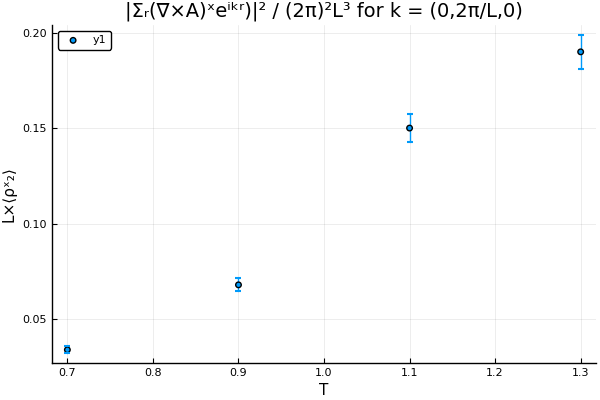

In [12]:
plt = scatter(T_list, L.*ρˣ₂_avg_by_T, yerror=L.*ρˣ₂_err_by_T; xlabel="T", ylabel="L×⟨ρˣ₂⟩", title="|Σᵣ(∇×A)ˣeⁱᵏʳ)|² / (2π)²L³ for k = (0,2π/L,0)")
display(plt)
savefig(plt, "x2_gauge_stiff_by_T.pdf")

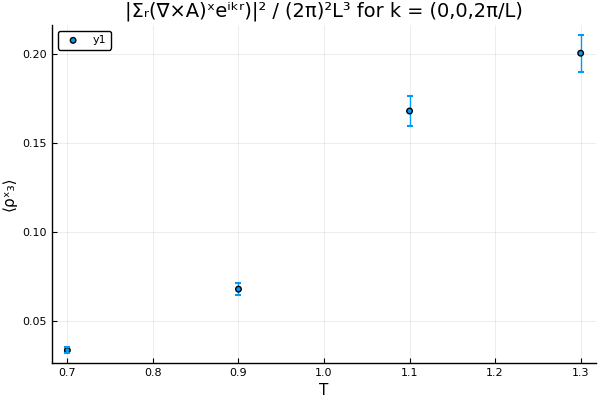

In [13]:

plt = scatter(T_list, L.*ρˣ₃_avg_by_T, yerror=L.*ρˣ₃_err_by_T; xlabel="T", ylabel="⟨ρˣ₃⟩", title="|Σᵣ(∇×A)ˣeⁱᵏʳ)|² / (2π)²L³ for k = (0,0,2π/L)")
display(plt)
savefig(plt, "x3_gauge_stiff_by_T.pdf")


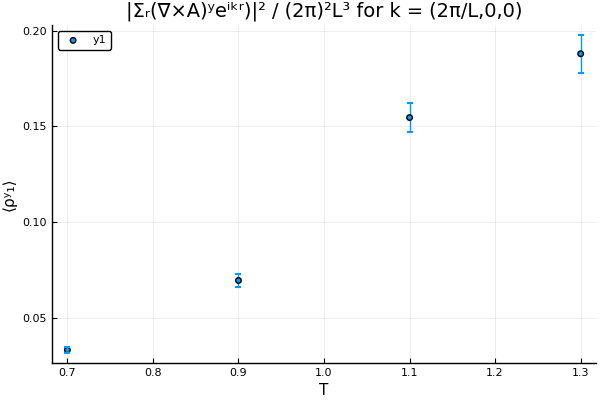

In [14]:
plt = scatter(T_list, L.*ρʸ₁_avg_by_T, yerror=L.*ρʸ₁_err_by_T; xlabel="T", ylabel="⟨ρʸ₁⟩", title="|Σᵣ(∇×A)ʸeⁱᵏʳ)|² / (2π)²L³ for k = (2π/L,0,0)")
display(plt)
savefig(plt, "y1_gauge_stiff_by_T.pdf")

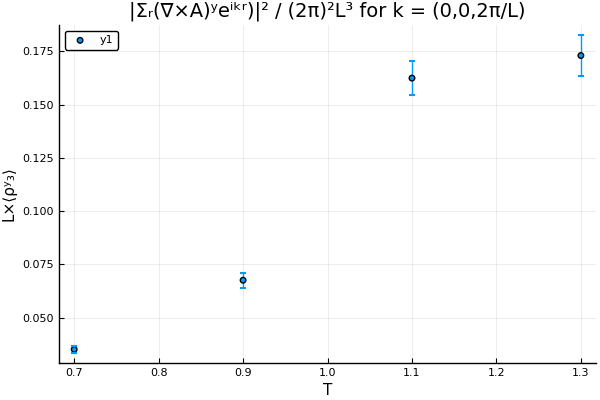

In [15]:
plt = scatter(T_list, L.*ρʸ₃_avg_by_T, yerror=L.*ρʸ₃_err_by_T; xlabel="T", ylabel="L×⟨ρʸ₃⟩", title="|Σᵣ(∇×A)ʸeⁱᵏʳ)|² / (2π)²L³ for k = (0,0,2π/L)")
display(plt)
savefig(plt, "y3_gauge_stiff_by_T.pdf")

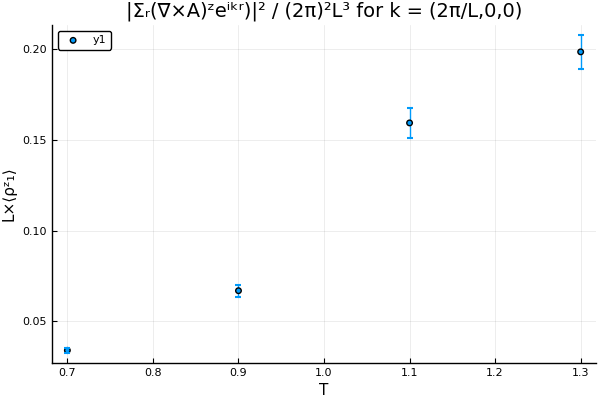

In [16]:
plt = scatter(T_list, L.*ρᶻ₁_avg_by_T, yerror=L.*ρᶻ₁_err_by_T; xlabel="T", ylabel="L×⟨ρᶻ₁⟩", title="|Σᵣ(∇×A)ᶻeⁱᵏʳ)|² / (2π)²L³ for k = (2π/L,0,0)")
display(plt)
savefig(plt, "z1_gauge_stiff_by_T.pdf")

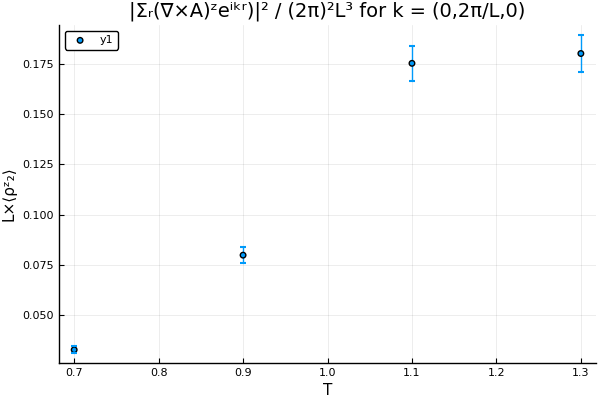

In [17]:
plt = scatter(T_list, L.*ρᶻ₂_avg_by_T, yerror=L.*ρᶻ₂_err_by_T; xlabel="T", ylabel="L×⟨ρᶻ₂⟩", title="|Σᵣ(∇×A)ᶻeⁱᵏʳ)|² / (2π)²L³ for k = (0,2π/L,0)")
display(plt)
savefig(plt, "z2_gauge_stiff_by_T.pdf")